In [1]:
import $ivy.`com.stripe::rainier-core:0.3.2`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [2]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [3]:
PPrint.register(repl)


In [4]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [5]:
val countriesSmooth = {
    val csvReader = CSVReader.open(new File("data/smooth_countries.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesSmooth: List[Map[String, String]] = List(
  Map("country" -> "Austria", "date" -> "2020-03-05", "cases" -> "11"),
  Map("country" -> "Austria", "date" -> "2020-03-06", "cases" -> "14"),
  Map("country" -> "Austria", "date" -> "2020-03-07", "cases" -> "18"),
  Map("country" -> "Austria", "date" -> "2020-03-08", "cases" -> "24"),
  Map("country" -> "Austria", "date" -> "2020-03-09", "cases" -> "33"),
  Map("country" -> "Austria", "date" -> "2020-03-10", "cases" -> "47"),
  Map("country" -> "Austria", "date" -> "2020-03-11", "cases" -> "63"),
  Map("country" -> "Austria", "date" -> "2020-03-12", "cases" -> "84"),
  Map("country" -> "Austria", "date" -> "2020-03-13", "cases" -> "104"),
  Map("country" -> "Austria", "date" -> "2020-03-14", "cases" -> "134"),
  Map("country" -> "Austria", "date" -> "2020-03-15", "cases" -> "165"),
  Map("country" -> "Austria", "date" -> "2020-03-16", "cases" -> "211"),
  Map("country" -> "Austria", "date" -> "2020-03-17", "cases" -> "257"),
  Map("c

In [6]:
def prepareDataForModel(xs: List[Long]): List[((Int, Long), Long)] = {
    val adjacentPairs = xs.drop(1).zip(xs.take(xs.size - 1))
    adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
        (i, kt_prev) -> kt
    }
}

defined function prepareDataForModel

In [7]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd6$Helper$$anon$1@1f1f71fa

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [8]:
def retry[T](maxAttempts: Int, isSuccessful: T => Boolean)(f: => T): T = {
    var i = 0
    
    do {
        val res = f
        i = i + 1
        if (isSuccessful(res))
            return res
        println(s"WARN: Attempt[$i] failed. Retrying...")
    } while (i < maxAttempts)
    sys.error("Exceeded maximum number of retries")
}

defined function retry

In [9]:
def predictRt(caseNumbers: List[Long]): (Vec[Real], List[Seq[Double]]) = {
    val data = prepareDataForModel(caseNumbers)
    
    val (model, rts) =  {
        val (xs, ys) = data.unzip

        val serialInterval = Normal(5,2).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
            val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
            Poisson(lambda)
        }

        (Model.observe(ys, likelihoods), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRt

In [10]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.94 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 2e+05 (11us) Total time: 5s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.83 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 2e+05 (12us) Total time: 4s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.91 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (11us) Total time: 4s

Chain 4 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.89 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (22us) Total time: 4s

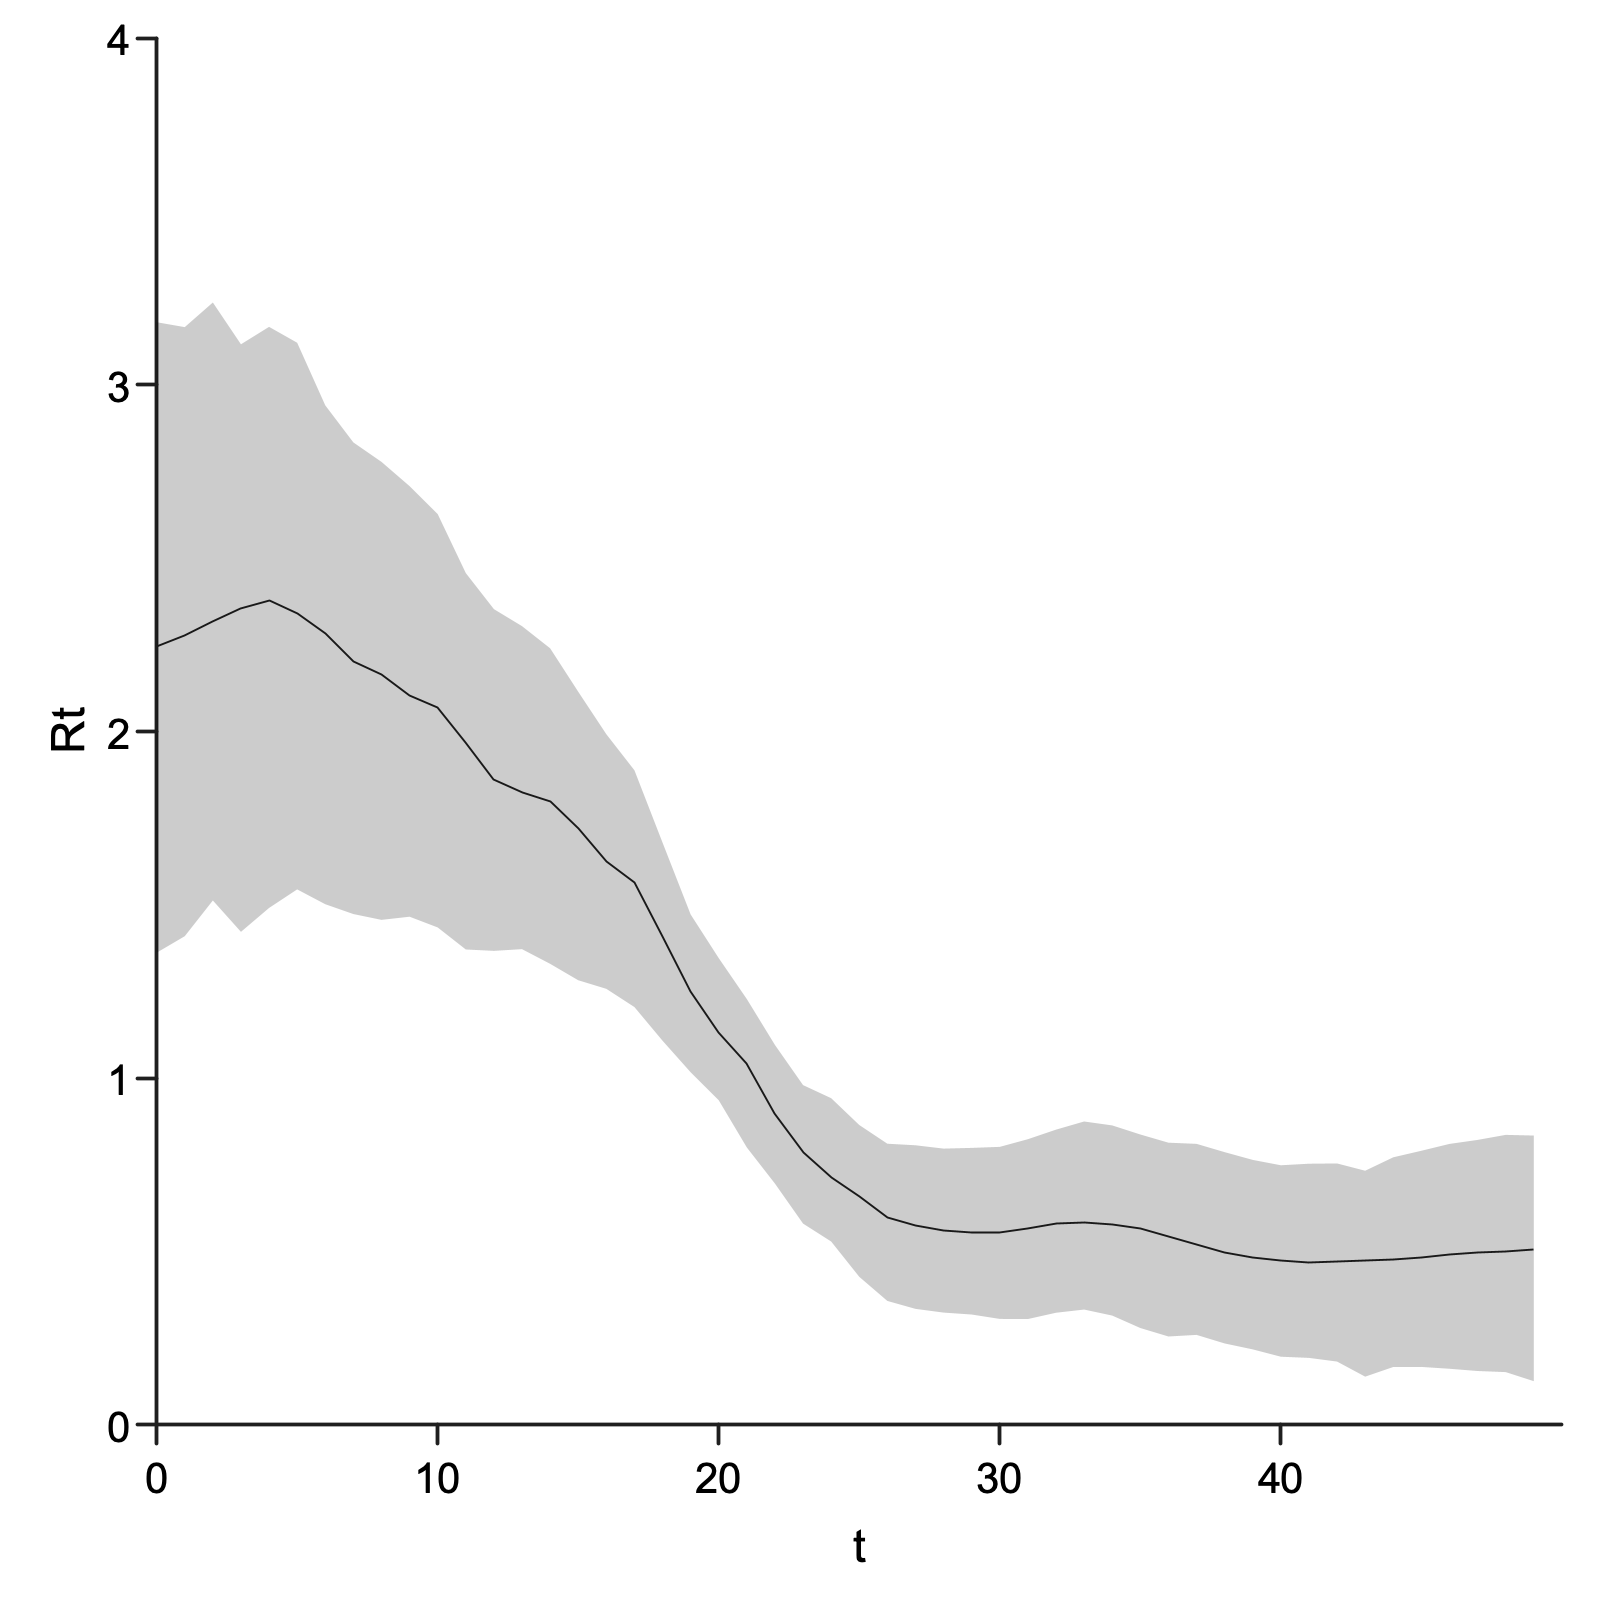

In [11]:
{{
    val countryName = "Austria"
    val caseNumbers = countriesSmooth.collect {
        case m if m("country") == countryName => m("cases").toLong
    }
    val (rts,estimates) = predictRt(caseNumbers)
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

In [12]:
val countriesToPredict = countriesSmooth.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [14]:
val countryStats: Map[String, RtsDistributionStats] = {
    assert(countriesToPredict.toSet.subsetOf(countriesSmooth.map(_("country")).toSet))
    val allStats = countriesToPredict.par.map { countryName =>
        val caseNumbers = countriesSmooth.collect {
            case m if m("country") == countryName => m("cases").toLong
        }
        val (rts,estimates) = predictRt(caseNumbers)
        val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
        println(s"$countryName [done]")
        countryName -> stats
    }.seq
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (1ms) Acceptance rate: 0.84 E-BFMI: 0.75 Step size: 0.07 Total gradient evaluations: 2e+05 (7us) Total time: 4s

Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.80 E-BFMI: 0.53 Step size: 0.05 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.64 Step size: 0.06 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.82 E-BFMI: 0.75 Step size: 0.06 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.89 E-BFMI: 0.63 Step size: 0.01 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.87 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (41us) Total time: 11s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (27us) Total time: 11s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.04 Total gradient evaluations: 2e+05 (29us) Total time: 14s

Chain 1 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.85 E-BFMI: 0.59 Step size: 0.04 Total gradient evaluations: 2e+05 (42us) Total time: 18s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.89 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (30us) Total time: 14s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.92 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 2e+05 (37us) Total time: 15s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (47us) Total time: 15s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.90 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Chain 1 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.93 E-BFMI: 0.70 Step size: 0.01 Total gradient evaluations: 2e+05 (52us) Total time: 23s

Chain 1 Complete : Iteration: 1000 (14ms) Acceptance rate: 0.93 E-BFMI: 0.67 Step size: 0.009 Total gradient evaluations: 2e+05 (70us) Total time: 29s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.82 E-BFMI: 0.76 Step size: 0.07 Total gradient evaluations: 2e+05 (8us) Total time: 3s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.80 E-BFMI: 0.73 Step size: 0.07 Total gradient evaluations: 2e+05 (9us) Total time: 4s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.81 E-BFMI: 0.73 Step size: 0.05 Total gradient evaluations: 2e+05 (26us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.78 E-BFMI: 0.67 Step size: 0.06 Total gradient evaluations: 2e+05 (22us) Total time: 10s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.87 E-BFMI: 0.64 Step size: 0.04 Total gradient evaluations: 2e+05 (22us) Total time: 10s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.92 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (24us) Total time: 11s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.87 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (1ms) Acceptance rate: 0.86 E-BFMI: 0.76 Step size: 0.06 Total gradient evaluations: 2e+05 (8us) Total time: 4s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.94 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 2e+05 (29us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.89 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.93 E-BFMI: 0.76 Step size: 0.02 Total gradient evaluations: 2e+05 (56us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.88 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.87 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Malta [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.80 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.67 E-BFMI: 0.77 Step size: 0.06 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (48us) Total time: 18s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.87 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (21us) Total time: 10s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.84 E-BFMI: 0.71 Step size: 0.05 Total gradient evaluations: 2e+05 (21us) Total time: 10s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (26us) Total time: 11s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.93 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (29us) Total time: 11s

Chain 2 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.90 E-BFMI: 0.51 Step size: 0.01 Total gradient evaluations: 2e+05 (52us) Total time: 23s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.87 E-BFMI: 0.71 Step size: 0.05 Total gradient evaluations: 2e+05 (20us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.86 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.55 Step size: 0.01 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.86 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (35us) Total time: 14s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.90 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (31us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (13ms) Acceptance rate: 0.94 E-BFMI: 0.63 Step size: 0.009 Total gradient evaluations: 2e+05 (63us) Total time: 28s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (26us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.84 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (22us) Total time: 10s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.84 E-BFMI: 0.67 Step size: 0.06 Total gradient evaluations: 2e+05 (21us) Total time: 10s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (36us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.89 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.60 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 15s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.93 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (26us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.88 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (27us) Total time: 11s

Lithuania [done]


Chain 1 Complete : Iteration: 1000 (12ms) Acceptance rate: 0.90 E-BFMI: 0.56 Step size: 0.006 Total gradient evaluations: 2e+05 (57us) Total time: 22s

Chain 3 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.83 E-BFMI: 0.61 Step size: 0.05 Total gradient evaluations: 2e+05 (40us) Total time: 17s

Hungary [done]


Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.94 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (27us) Total time: 12s

Latvia [done]


Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (30us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.93 E-BFMI: 0.70 Step size: 0.01 Total gradient evaluations: 2e+05 (26us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (26us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.91 E-BFMI: 0.60 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.92 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (84us) Total time: 14s

Chain 4 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 14s

Ireland [done]


Chain 4 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.93 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 14s

Chain 3 Complete : Iteration: 1000 (12ms) Acceptance rate: 0.92 E-BFMI: 0.55 Step size: 0.01 Total gradient evaluations: 2e+05 (58us) Total time: 22s

Poland [done]


Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.87 E-BFMI: 0.75 Step size: 0.05 Total gradient evaluations: 2e+05 (23us) Total time: 10s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.92 E-BFMI: 0.59 Step size: 0.02 Total gradient evaluations: 2e+05 (32us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (45us) Total time: 18s

Slovakia [done]


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.80 E-BFMI: 0.67 Step size: 0.06 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.74 E-BFMI: 0.55 Step size: 0.06 Total gradient evaluations: 2e+05 (48us) Total time: 12s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.86 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (35us) Total time: 14s

Russia [done]


Chain 1 Complete : Iteration: 1000 (12ms) Acceptance rate: 0.87 E-BFMI: 0.53 Step size: 0.008 Total gradient evaluations: 2e+05 (54us) Total time: 23s

Chain 3 Complete : Iteration: 1000 (16ms) Acceptance rate: 0.95 E-BFMI: 0.68 Step size: 0.008 Total gradient evaluations: 2e+05 (80us) Total time: 32s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.78 E-BFMI: 0.69 Step size: 0.05 Total gradient evaluations: 2e+05 (26us) Total time: 11s

Austria [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.87 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.92 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (39us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (13ms) Acceptance rate: 0.85 E-BFMI: 0.60 Step size: 0.007 Total gradient evaluations: 2e+05 (59us) Total time: 25s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.90 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (39us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.70 Step size: 0.05 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Switzerland [done]


Chain 1 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.87 E-BFMI: 0.59 Step size: 0.03 Total gradient evaluations: 2e+05 (44us) Total time: 18s

Netherlands [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.60 Step size: 0.05 Total gradient evaluations: 2e+05 (32us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.89 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 2e+05 (31us) Total time: 14s

Slovenia [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.87 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (35us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.88 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.66 Step size: 0.05 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (14ms) Acceptance rate: 0.92 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (71us) Total time: 26s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.92 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.86 E-BFMI: 0.60 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 15s

Greece [done]


Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.87 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.89 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (37us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.90 E-BFMI: 0.55 Step size: 0.008 Total gradient evaluations: 2e+05 (58us) Total time: 24s

Chain 4 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.96 E-BFMI: 0.83 Step size: 0.005 Total gradient evaluations: 2e+05 (32us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.89 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (31us) Total time: 18s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (28us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.86 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (27us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (28us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.87 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.90 E-BFMI: 0.57 Step size: 0.007 Total gradient evaluations: 2e+05 (58us) Total time: 25s

Cyprus [done]


Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.89 E-BFMI: 0.66 Step size: 0.04 Total gradient evaluations: 2e+05 (41us) Total time: 15s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.88 E-BFMI: 0.75 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 14s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.61 Step size: 0.05 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.89 E-BFMI: 0.68 Step size: 0.009 Total gradient evaluations: 2e+05 (58us) Total time: 29s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.89 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.79 E-BFMI: 0.64 Step size: 0.05 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Croatia [done]


Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (35us) Total time: 15s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 2e+05 (37us) Total time: 15s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.86 E-BFMI: 0.63 Step size: 0.008 Total gradient evaluations: 2e+05 (28us) Total time: 11s

Germany [done]


Chain 3 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (36us) Total time: 16s

Chain 4 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.91 E-BFMI: 0.72 Step size: 0.04 Total gradient evaluations: 2e+05 (33us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.90 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.92 E-BFMI: 0.59 Step size: 0.008 Total gradient evaluations: 2e+05 (30us) Total time: 20s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.83 E-BFMI: 0.72 Step size: 0.06 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.88 E-BFMI: 0.72 Step size: 0.04 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.74 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.05 Total gradient evaluations: 2e+05 (21us) Total time: 11s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.91 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 2e+05 (26us) Total time: 12s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (27us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.92 E-BFMI: 0.63 Step size: 0.007 Total gradient evaluations: 2e+05 (29us) Total time: 18s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.86 E-BFMI: 0.60 Step size: 0.04 Total gradient evaluations: 2e+05 (20us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.92 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Finland [done]


Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (17us) Total time: 10s

Bulgaria [done]


Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (32us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.66 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 10s

Belgium [done]
Estonia [done]


Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.59 Step size: 0.02 Total gradient evaluations: 2e+05 (16us) Total time: 8s

Italy [done]


Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.97 E-BFMI: 0.17 Step size: 0.0002 Total gradient evaluations: 2e+05 (25us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 8s

Sweden [done]


Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.93 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Luxembourg [done]


Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.87 E-BFMI: 0.59 Step size: 0.03 Total gradient evaluations: 2e+05 (13us) Total time: 6s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.91 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (15us) Total time: 6s

Denmark [done]
France [done]


Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.92 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Czechia [done]
Portugal [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.65 Step size: 0.008 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Romania [done]
Norway [done]


Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.65 Step size: 0.008 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.67 Step size: 0.007 Total gradient evaluations: 2e+05 (23us) Total time: 8s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.54 Step size: 0.009 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Spain [done]


countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.9466151990983145),
      (1, 1.9454693219348485),
      (2, 1.9363908187028396),
      (3, 1.9205302872341534),
      (4, 1.89496480701147),
      (5, 1.8664100958315786),
      (6, 1.8415609930132282),
      (7, 1.808509312294386),
      (8, 1.7790694487194023),
      (9, 1.7532151682714816),
      (10, 1.7189084662542484),
      (11, 1.6888259603596114),
      (12, 1.6607621827215684),
      (13, 1.6313635823210593),
      (14, 1.594090050996853),
      (15, 1.5557719766623763),
      (16, 1.5298780583724498),
      (17, 1.5030157116563538),
      (18, 1.4860302250940272),
      (19, 1.462493206381825),
      (20, 1.4237310291926917),
      (21, 1.3908593150068314),
      (22, 1.3395863942109094),
      (23, 1.2973031955201368),
      (24, 1.2457664430267124),
      (25, 1.1891713325533628),
      (26, 1.1391337754684772),
      (27, 1.0924311445950599),
      (28, 1.053

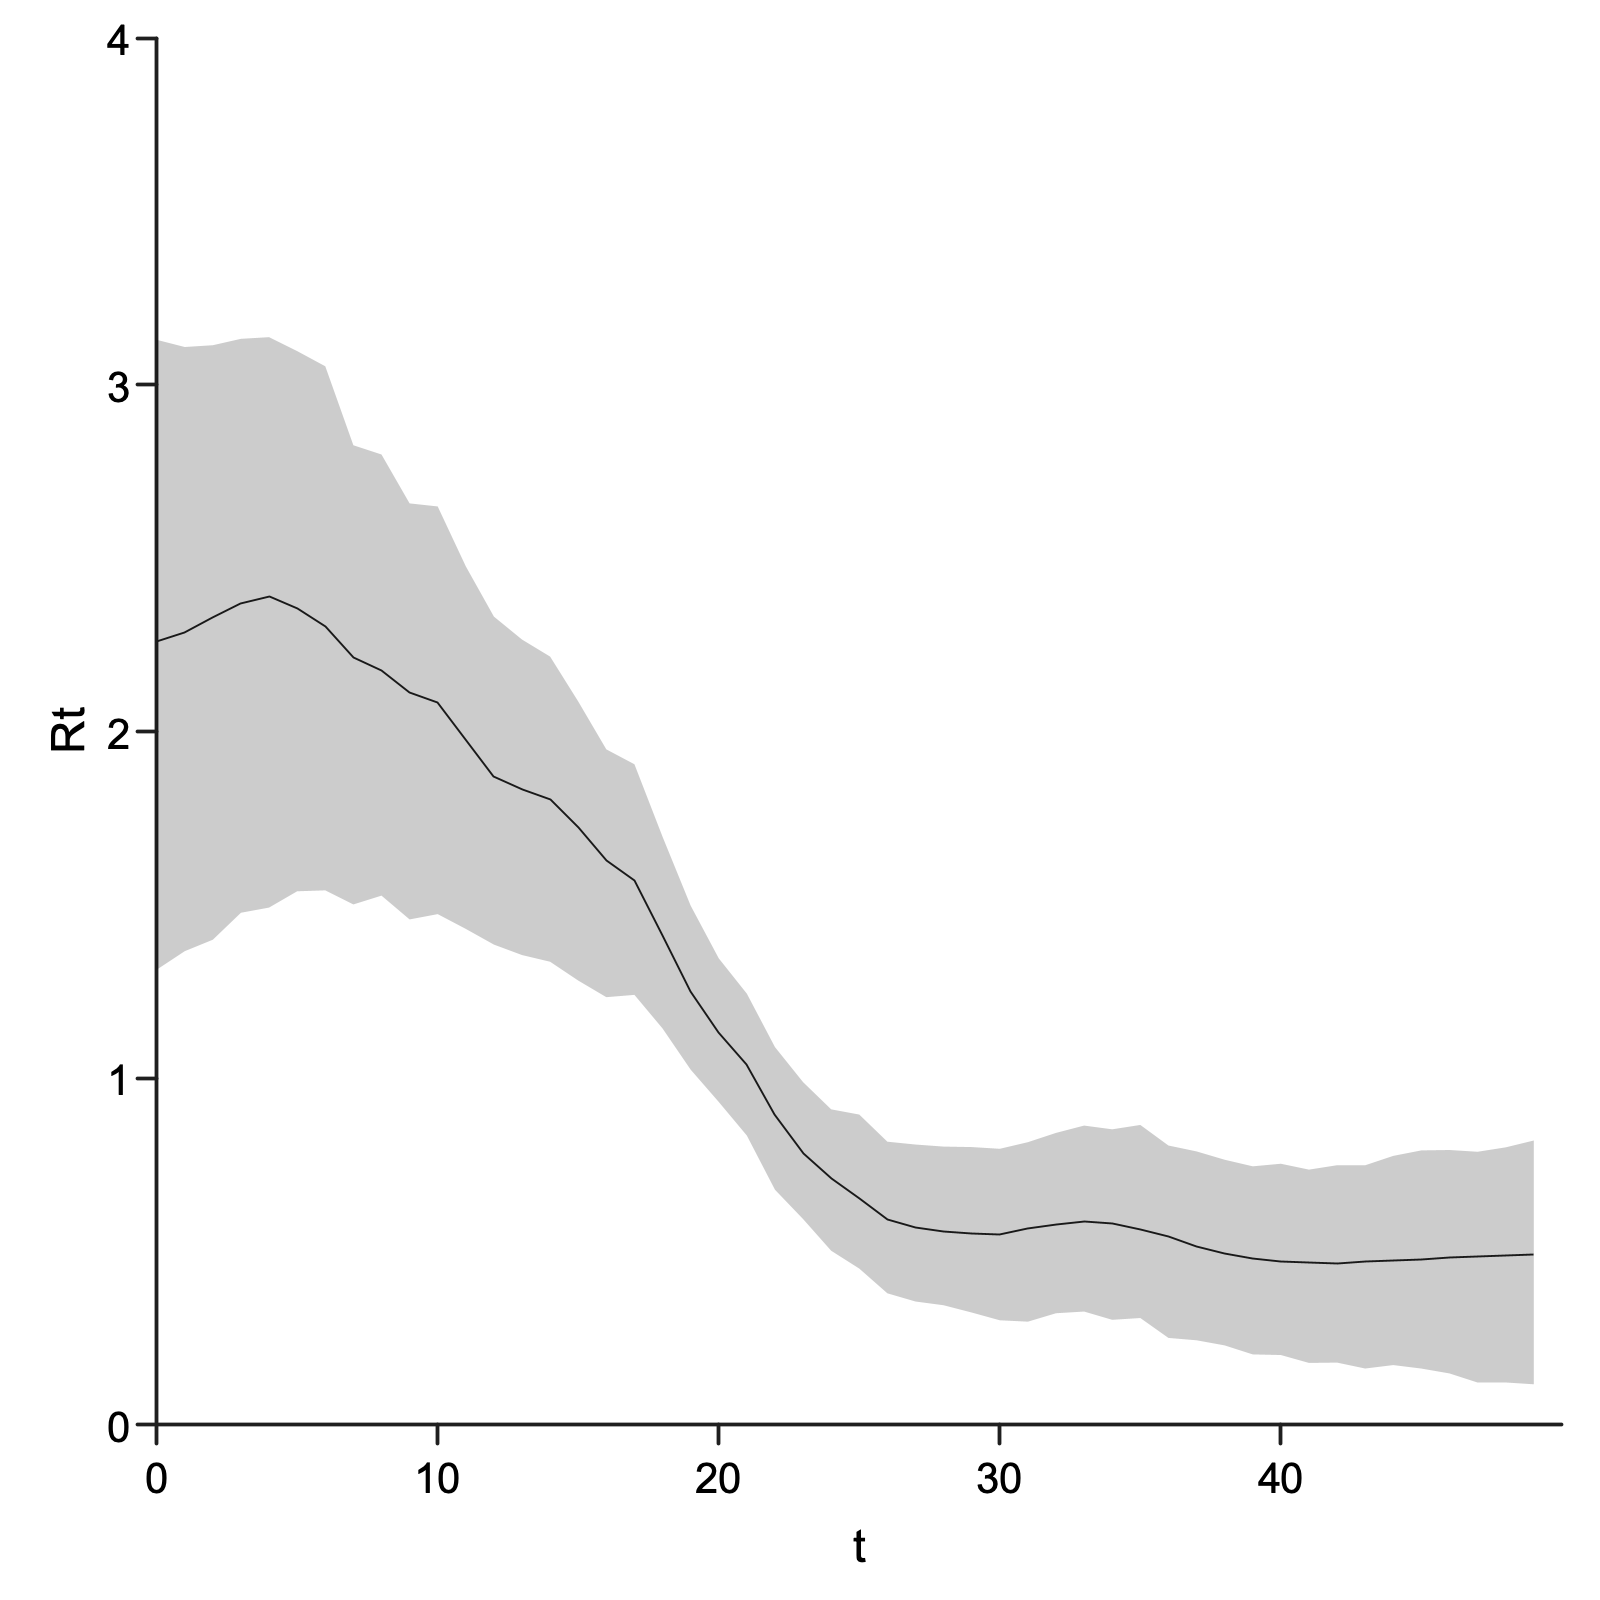

In [15]:
{{
    val RtsDistributionStats(means, hdpis) = countryStats("Austria")
    show("t", "Rt", line(means), shade(hdpis))
}}

In [16]:
def datesForCountry(country: String) = {
    countriesSmooth.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [17]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country)
    assert(xs.size == dates.size)
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [18]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@5d0076ff

In [19]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [20]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [21]:
csvWriter.close()

Changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a Laplace transition to strongly regularize
* put a prior on the std dev of the transition, rather than fixing it
* put a prior on the serial interval rather than fixing it

In [5]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val serialInterval = Normal(5,2).latent
    val logR0 = Normal(0, 1).latent
    val sigma = Exponential(10).latent
    val diffs = Laplace(0,sigma).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [8]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

In [9]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}

In [39]:
rts